In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [3]:
df = pd.read_csv("AmesHousing.csv")

In [5]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, "SalePrice")

In [7]:
# Handle categorical and numerical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("SalePrice")  # Remove target from numeric features


In [9]:
# Imputation and scaling pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

In [11]:
# Define features and target
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Apply log transformation to target to normalize skewness
y = np.log1p(y)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [15]:
# Function to compute evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test) - X_test.shape[1] - 1)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5)) * 100
    
    return [round(r2, 3), round(adj_r2, 3), round(mse, 3), round(rmse, 3), round(mae, 3), round(cv_score, 3)]

In [17]:
# Initialize models with improved hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Multi-Layer Perceptron": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=12, max_features='sqrt', random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=100, gamma=0.1),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
}


In [19]:
# Evaluate models and store results
results = {}
for name, model in tqdm(models.items()):
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics

# Create DataFrame with results
columns = ["R Sq.", "Adj. R Sq.", "MSE", "RMSE", "MAE", "C V Score"]
results_df = pd.DataFrame(results, index=columns).T

# Convert target variable back from log scale for interpretation
results_df["MSE"] = np.expm1(results_df["MSE"])
results_df["RMSE"] = np.expm1(results_df["RMSE"])
results_df["MAE"] = np.expm1(results_df["MAE"])

# Display results
print(results_df)


100%|██████████| 5/5 [06:04<00:00, 72.87s/it] 

                           R Sq.  Adj. R Sq.       MSE      RMSE       MAE  \
Linear Regression          0.831       0.632  0.023267  0.165325  0.086542   
Multi-Layer Perceptron     0.473      -0.145  0.075731  0.309964  0.117395   
Random Forest              0.852       0.679  0.020201  0.153730  0.096365   
Support Vector Regression  0.504      -0.077  0.071436  0.299527  0.186491   
XGBoost                    0.893       0.768  0.015113  0.129754  0.081123   

                           C V Score  
Linear Regression             82.534  
Multi-Layer Perceptron        64.004  
Random Forest                 84.486  
Support Vector Regression     47.566  
XGBoost                       88.441  


In [21]:
results_df.head()

,R Sq.,Adj. R Sq.,MSE,RMSE,MAE,C V Score
Linear Regression,0.831,0.632,0.023267,0.165325,0.086542,82.534
Multi-Layer Perceptron,0.473,-0.145,0.075731,0.309964,0.117395,64.004
Random Forest,0.852,0.679,0.020201,0.153730,0.096365,84.486
Support Vector Regression,0.504,-0.077,0.071436,0.299527,0.186491,47.566
XGBoost,0.893,0.768,0.015113,0.129754,0.081123,88.441


In [23]:
# Evaluate models and store results
results = {}
for name, model in tqdm(models.items()):
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics

# Create DataFrame with results
columns = ["R Sq.", "Adj. R Sq.", "MSE", "RMSE", "MAE", "C V Score"]
results_df = pd.DataFrame(results, index=columns).T

# Convert target variable back from log scale for interpretation
results_df["MSE"] = np.expm1(results_df["MSE"])
results_df["RMSE"] = np.expm1(results_df["RMSE"])
results_df["MAE"] = np.expm1(results_df["MAE"])

# Display results
print(results_df)


100%|██████████| 5/5 [04:42<00:00, 56.52s/it]

                           R Sq.  Adj. R Sq.       MSE      RMSE       MAE  \
Linear Regression          0.831       0.632  0.023267  0.165325  0.086542   
Multi-Layer Perceptron     0.473      -0.145  0.075731  0.309964  0.117395   
Random Forest              0.852       0.679  0.020201  0.153730  0.096365   
Support Vector Regression  0.504      -0.077  0.071436  0.299527  0.186491   
XGBoost                    0.893       0.768  0.015113  0.129754  0.081123   

                           C V Score  
Linear Regression             82.534  
Multi-Layer Perceptron        64.004  
Random Forest                 84.486  
Support Vector Regression     47.566  
XGBoost                       88.441  


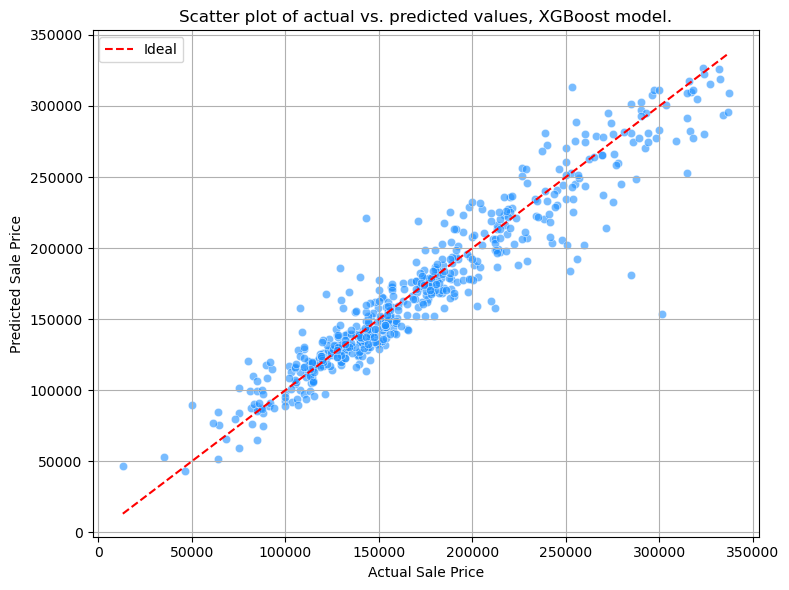

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train best model again (or use an already trained one)
best_model = models["XGBoost"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Convert back from log scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='dodgerblue')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         '--', color='red', label='Ideal')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Scatter plot of actual vs. predicted values, XGBoost model.")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
